TODO: re-run to get filtered instances and shap values

In [1]:
import shap
import pickle
import numpy as np
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
from sklearn.utils import resample
shap.initjs()
%matplotlib inline
task_name = '01'
sample_explain_data = None

In [2]:
with open(task_name + '.dataset', 'rb') as f:
    X, display_data, y, feature_names = pickle.load(f)
with open(task_name + '.models', 'rb') as f:
    comparer = pickle.load(f)

In [4]:
try:
    with open(task_name + '.expl', 'rb') as f:
        explanations = \
            pickle.load(f) #, indices_nonfinite_predictions, explanations_nonfinite
    print('loaded saved SHAP values')
except FileNotFoundError:
    pass

loaded saved SHAP values


# Explain using Interpretability Methods

In [ ]:
if sample_explain_data is not None:
    # stratified sample across diff classes
    mclass_diff = comparer.predict_mclass_diff(X)
    X_explain, display_data_explain, y_explain = resample(X, display_data, y,
                                                          n_samples=sample_explain_data, replace=False,
                                                          stratify=mclass_diff, random_state=0)
    comparer.plot_confusion_matrix(X_explain)
else:
    X_explain, display_data_explain, y_explain = X, display_data, y

In [10]:
%%time
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X_explain, display_data_explain)
with open(task_name + '.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite),
                f, pickle.HIGHEST_PROTOCOL)

Permutation explainer: 32562it [03:32, 148.05it/s]                           
Permutation explainer: 32562it [03:54, 133.14it/s]                           
Permutation explainer: 32562it [03:21, 153.77it/s]                           
Permutation explainer: 32562it [03:46, 137.53it/s]                           
Permutation explainer:   4%|▍         | 1242/32561 [00:10<04:21, 119.75it/s]divide by zero encountered in log
divide by zero encountered in log
Permutation explainer:   7%|▋         | 2312/32561 [00:19<04:18, 116.93it/s]divide by zero encountered in log
invalid value encountered in subtract
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
invalid value encountered in subtract
invalid value encountered in subtract
divide by zero encountered in log
divide by zero encountered in log
Permutation explainer:   7%|▋         | 2361/32561 [00:19<04:18, 116.89it/s]divide by zero encountered in log
invalid value encountered in subtrac

CPU times: user 1h 47min 15s, sys: 9min 54s, total: 1h 57min 10s
Wall time: 59min 54s


In [21]:
indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((0,), (0,))

# Global Explanations

## Feature importance

### Individual explanations

First, let's derive a shared feature order from A and B's SHAP values in log odds space, that orders them by mean absolute influence from highest to lowest. This makes the following plots easier to compare.

In [8]:
feature_order, feature_importance = calc_feature_order(explanations.indiv.log_odds[:, :, 1])

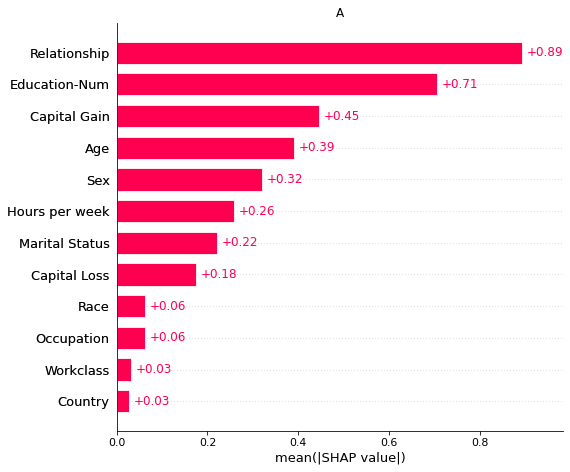

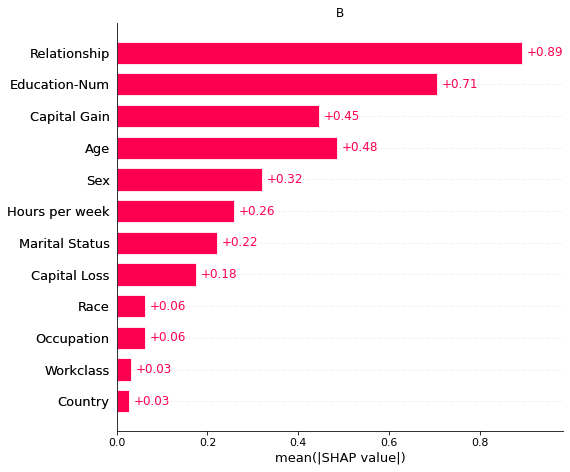

In [10]:
plot_feature_importance_bar(explanations.indiv.log_odds.A[:, :, 1], title='A', feature_order=feature_order)
plot_feature_importance_bar(explanations.indiv.log_odds.B[:, :, 1], title='B', feature_order=feature_order)

We notice a difference: Age is more important in model B. Let's check that in more detail in the scatter plot of the SHAP value distribution.

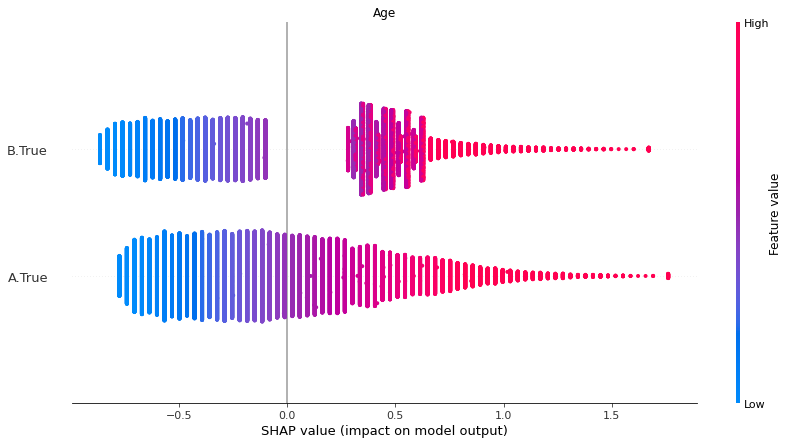

In [14]:
plot_feature_importance_scatter(explanations.indiv.log_odds[:, ['Age'], 1])

We clearly see, that there are no SHAP values in the range of about -0.1 to 0.3, but they seem to be shifted right. The other don't seem to be different at all, when we check the aggregated mean per feature of the subtracted SHAP values.

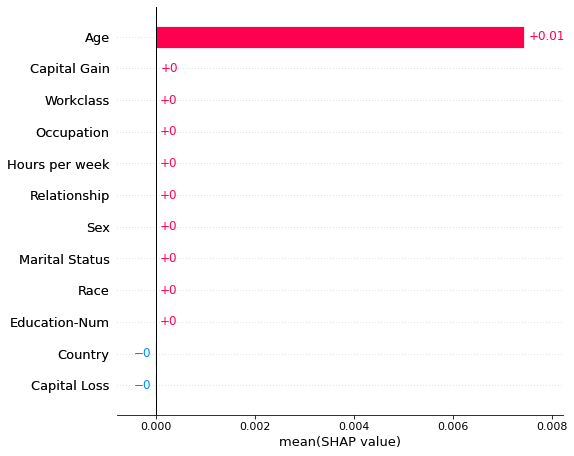

In [15]:
plot_feature_importance_bar(explanations.indiv_diff.log_odds[:, :, 1].mean(0))

### Difference classifier explanations

Let's derive a feature order first, from the one with the biggest log odds of being different to lowest. We will use the SHAP values for predicted labels this time, because otherwise we do not get the perturbed feature ranked first.  That's because it gets lost in the general uncertainties of the two classifiers. SHAP vaues for predicted labels force higher influences into the explanations, because they need to sum up to 1 for all instances where the classifiers predict unequal outcomes.

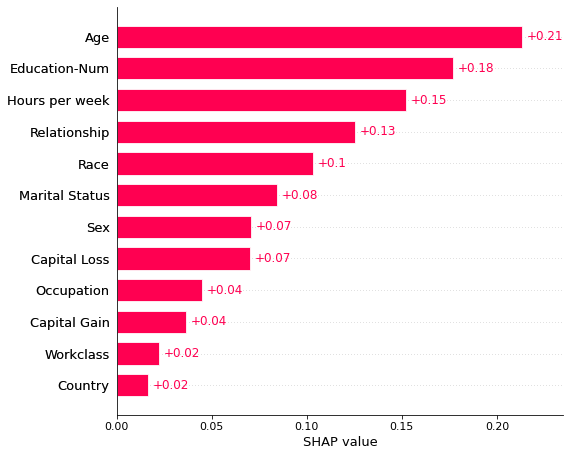

In [40]:
feature_order, feature_importance = calc_feature_order(explanations.bin_diff.labels[is_pred_diff])
plot_feature_importance_bar(feature_importance)

Let's visualize the log odds SHAP values of the top 3. In the difference class distributions, we notice a different shape for Age only. $(False, True)$, which is the only difference class present, seems to have a second cluster with higher SHAP values.

In [44]:
explanations_top3_features = explanations[:, feature_order[:3]]

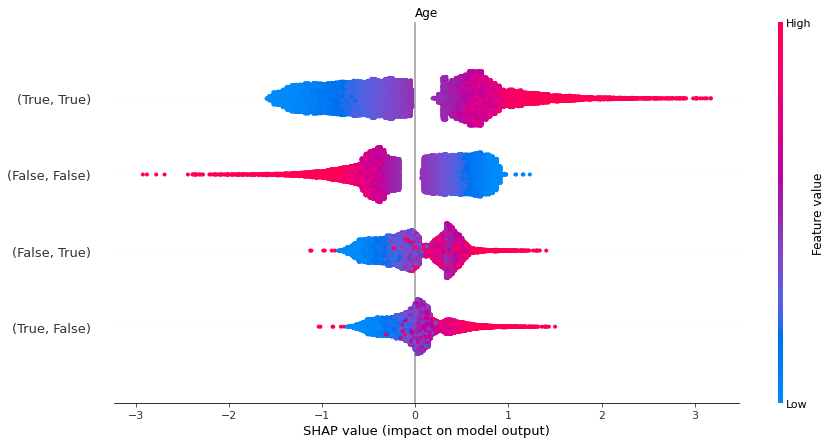

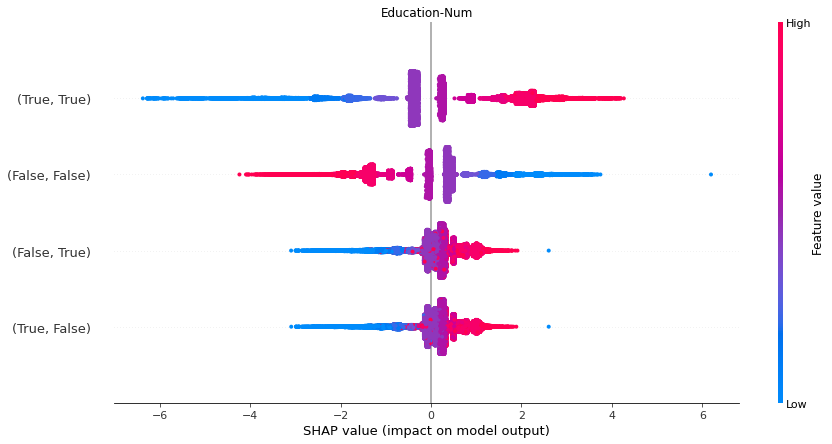

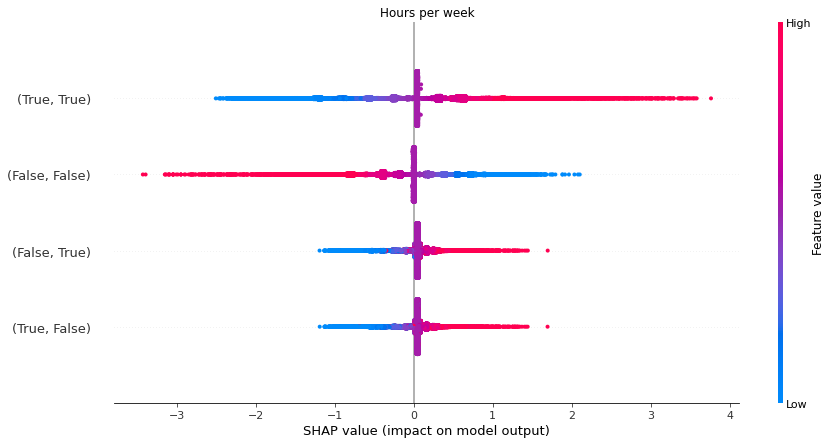

In [46]:
plot_feature_importance_scatter(explanations_top3_features.mclass_diff.log_odds)

## Feature effects

In [42]:
is_pred_diff = comparer.predict_bin_diff(explanations.data)

### Individual explanations

We can see clearly, that for the feature Age both classifiers differ. We do not see any interactions, as was expected for logistic regression models. But we see increased SHAP values for the age group of 40-50. It's hard or even impossible to spot the instances with unequal outcomes colored red, because they are plot over by blue instances, that have equal outcomes.

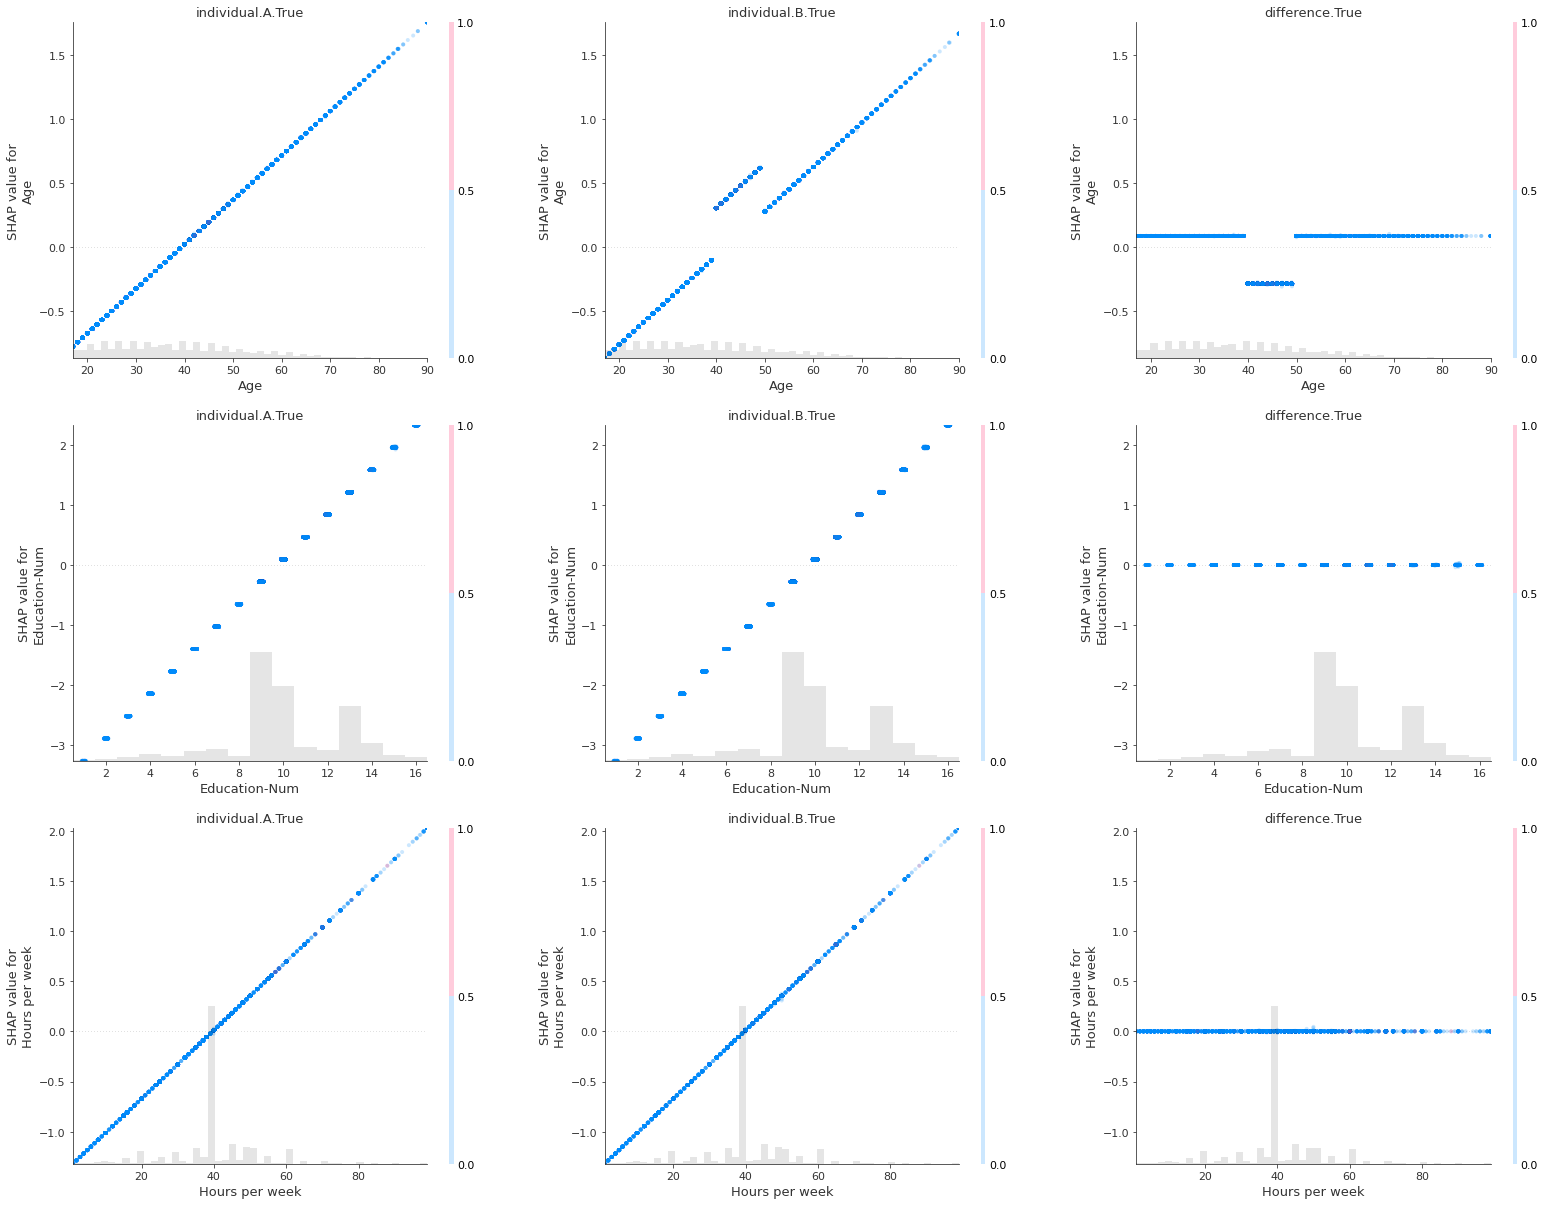

In [52]:
plot_feature_effects(merge_explanations(individual=explanations_top3_features.indiv.log_odds[:, :, 1],
                                        difference=explanations_top3_features.indiv_diff.log_odds[:, :, 1]),
                     color=is_pred_diff, alpha=0.2)

### Difference classifier explanations

First, let's check both label SHAP value effects and log-odds SHAP values effects, because the former provided better ranking results earlier.

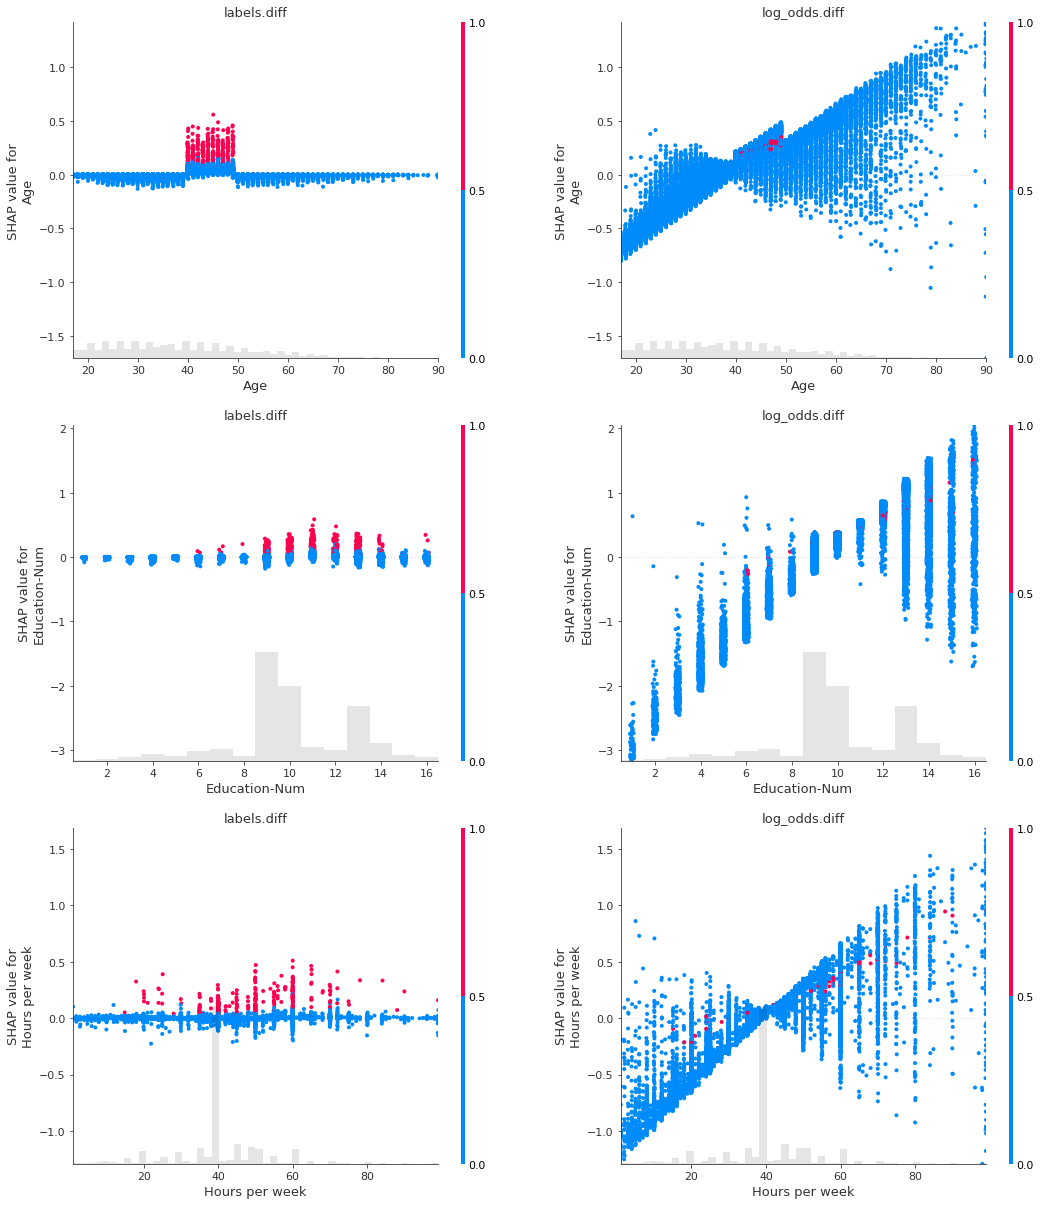

In [56]:
plot_feature_effects(merge_explanations(labels=explanations_top3_features.bin_diff.labels,
                                        log_odds=explanations_top3_features.bin_diff.log_odds),
                     color=is_pred_diff)

In the plot of label SHAP values for Age, we notice the group with higher SHAP values for 40-50, but some that do not classify as unequal with a bit higher shap values as well. That's because they still have a higher probability as classifying as unequal compared to those <40 or >50. In the log-odds column, we still see the same effect but huge interaction effects. let's check that in more detail:

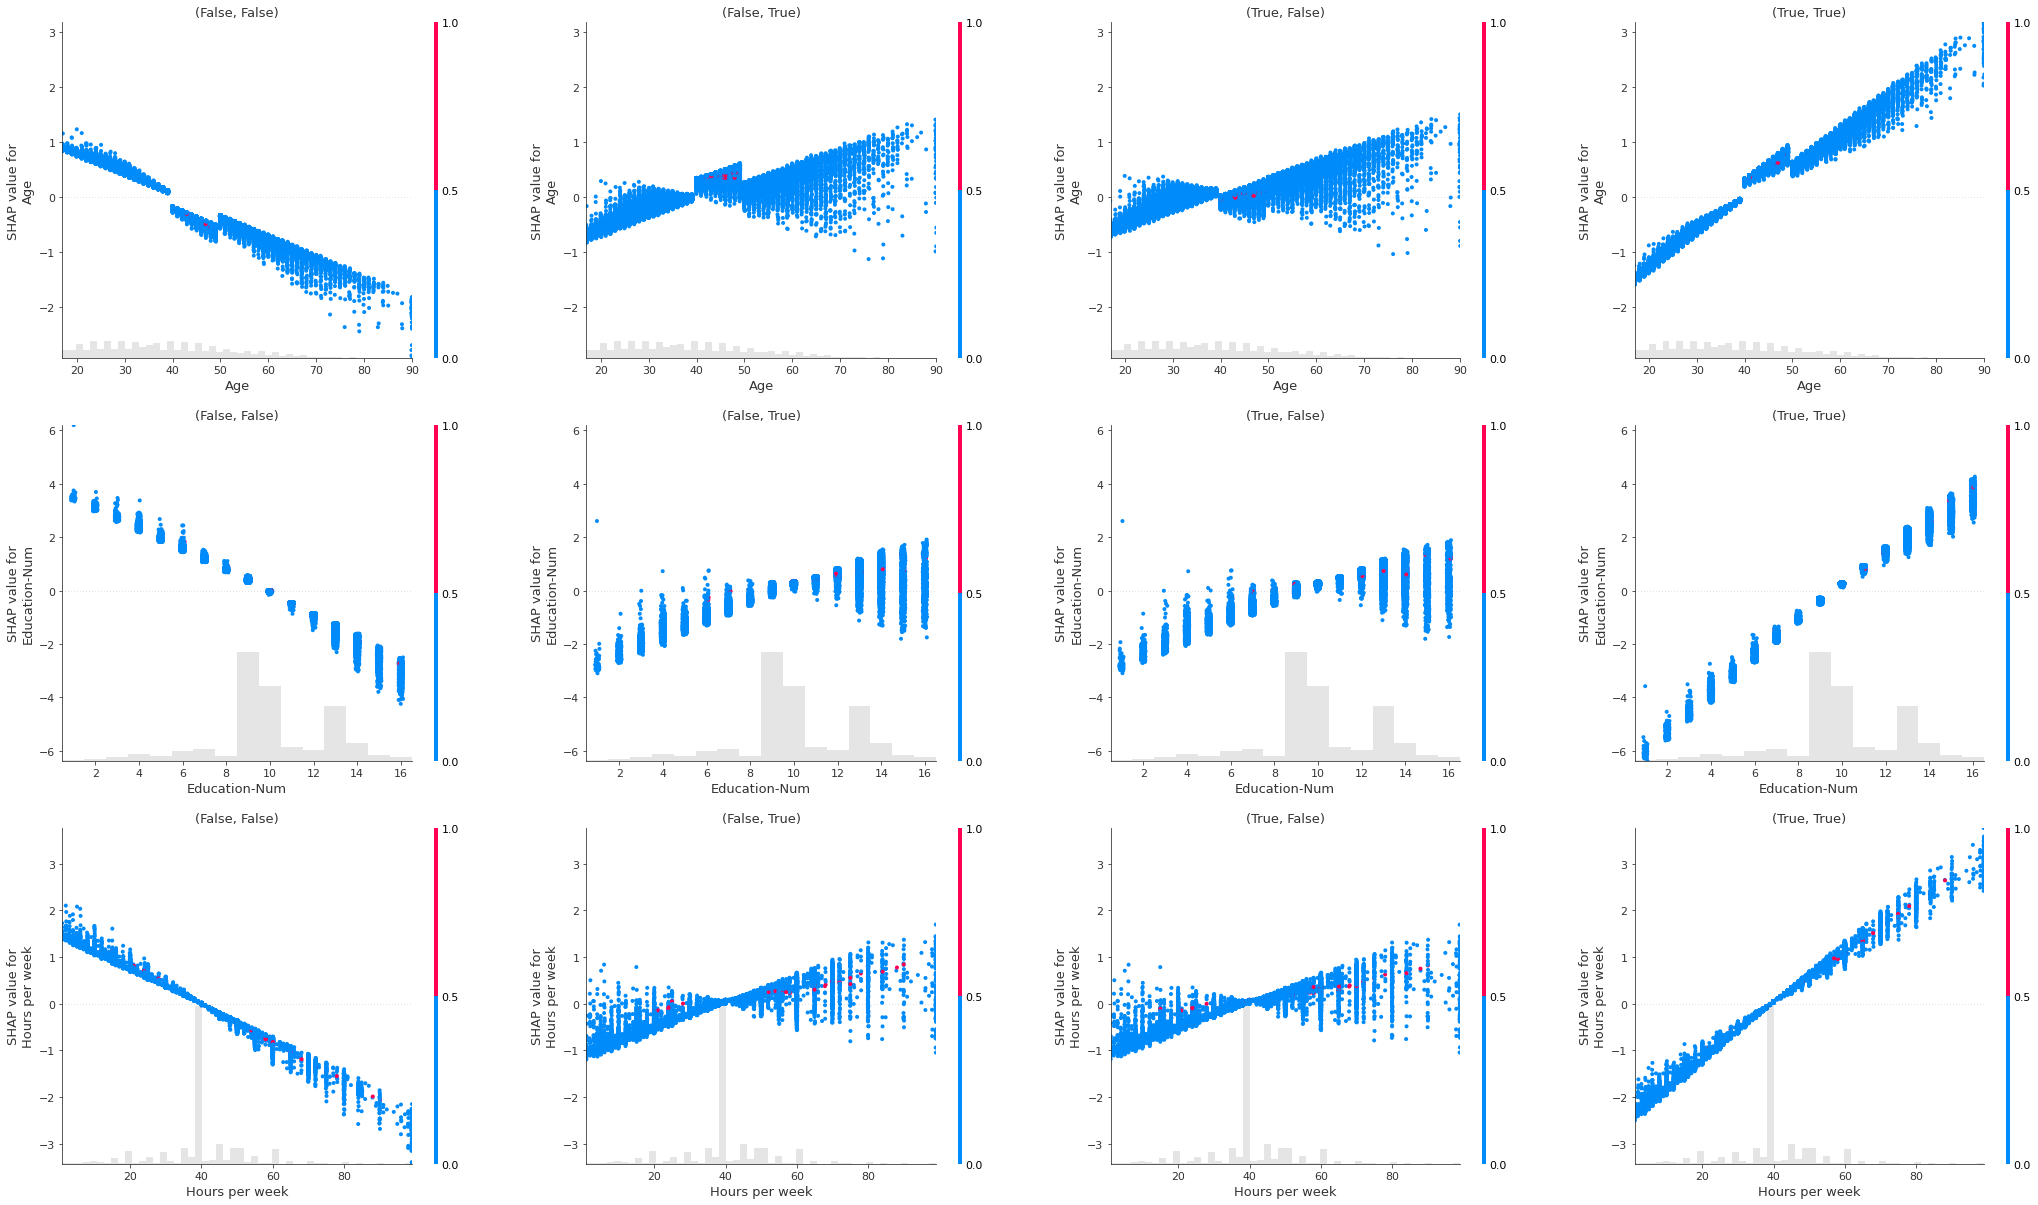

In [57]:
plot_feature_effects(explanations_top3_features.mclass_diff.log_odds, color=is_pred_diff)